# step1 确定条件 

y的值: [4.97870684e-02 1.49361205e-01 2.24041808e-01 2.24041808e-01
 1.68031356e-01 1.00818813e-01 5.04094067e-02 2.16040315e-02
 8.10151179e-03 2.70050393e-03 8.10151179e-04 2.20950322e-04
 5.52375804e-05 1.27471339e-05 2.73152870e-06 5.46305740e-07
 1.02432326e-07 1.80762929e-08 3.01271548e-09 4.75691918e-10
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


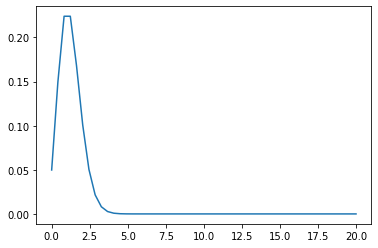

In [476]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson #引入泊松分布
max_cars=20         #设定每个地方的最大车的数量
rental_lambda_A=3   #A地的lambda值为3
rental_lambda_B=4   #B地的lammbda值为4
return_lambda_A=3   #A地的lambda值为3
return_lambda_B=2   #B地的lambda值为2
cost_move=-2        #移动车辆的代价
reward_rental=10    #租出车辆的回报
terminl_poisson=11  #poison终止计算值，这样可以提前结束计算  后面没有用为了方便直接用的11
x=np.linspace(0,20)
y=np.zeros(x.shape)
for i in range(20):
    y[i]=poisson.pmf(i,return_lambda_A)
plt.plot(x,y)
print("y的值:",y)

# step2 计算参数

In [477]:
trans_probility=np.zeros(2*21*21).reshape(2,21,21)   #创建一个2*21*21的状态转移矩阵，其中0表示A地，1表示B，表示第一个参数i到第二个参数j的概率
reward=np.zeros(2*21).reshape(2,21)     #这里将reward定义为一个二维组，第一行代表A地的不同状态所得的reward，第二行表示B

In [478]:
for k in range(21):
    for i in range(12):          #租车车数
        for j in range(12):      #还车数
            s=k-i+j
            if k-i>0:
                if k-i+j>20:
                    s=20      
            elif k-i<0:
                s=j              #转移后不能超出范围
            trans_probility[0,k,s]+=poisson.pmf(i,rental_lambda_A)*poisson.pmf(j,return_lambda_A)
            trans_probility[1,k,s]+=poisson.pmf(i,rental_lambda_B)*poisson.pmf(j,return_lambda_B)

In [479]:
print(trans_probility[0,1].sum())
print(trans_probility[0,0])

0.9998572318381027
[4.97835142e-02 1.49350543e-01 2.24025814e-01 2.24025814e-01
 1.68019361e-01 1.00811616e-01 5.04058082e-02 2.16024892e-02
 8.10093346e-03 2.70031115e-03 8.10093346e-04 2.20934549e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


In [480]:
for i in range(21):
    for j in range(21):   #最多租出i辆车,且最多可以计算到11，这里为了更高精度计算到了20，即最大容量。
        reward[0,i]+=poisson.pmf(j,rental_lambda_A)*reward_rental*min(i,j)
        reward[1,i]+=poisson.pmf(j,rental_lambda_B)*reward_rental*min(i,j)
print(reward[0])

[ 0.          9.50212932 17.51064658 23.27874577 26.80642688 28.65379444
 29.49297386 29.82805921 29.94710425 29.98513417 29.99615905 29.99908242
 29.99979629 29.99995778 29.99999179 29.9999985  29.99999974 29.99999996
 29.99999999 30.         30.        ]


In [481]:
print(reward[1])

[ 0.          9.81684359 18.90106163 26.52002855 32.18532733 35.89695796
 38.04565407 39.15239383 39.66372997 39.8773643  39.95868671 39.98708435
 39.99623662 39.99897377 39.99973704 39.99993633 39.99998524 39.99999655
 39.99999901 39.99999951 39.99999959]


# step3 定义value更新函数

In [482]:
value=np.zeros(21*21).reshape(21,21)
policy=np.zeros(value.shape,dtype=int)  #这里构造了21*21的value和policy用于存放value和policy

In [483]:
def value_update(state,action,old_value):     #定义一个value值更新的函数，传递参数有当前状态、动作、旧的value值
    new_state=state                           #转移后的新状态初值默认和原来一样
    new_value=0
    new_state[0]=min(state[0]-action,20)
    new_state[1]=min(state[1]+action,20)
    cost=abs(action)*2
    new_value=-cost
    for i in range(21):                     #计算每个状态到其他状态的value
        for j in range(21):
            new_value+=trans_probility[0,new_state[0],i]*trans_probility[1,new_state[1],j]*(reward[0,new_state[0]]+reward[1,new_state[1]]+0.9*old_value[i,j])
    return new_value

# step4 定义画图函数 

In [484]:
from mpl_toolkits.mplot3d import Axes3D

In [485]:
def draw_graph(iteration):                                   #这里只需要传递迭代参数，只需要把每次运行完后的value和policy画出来就行了
    fig = plt.figure(figsize=(18, 18))
    ax = fig.add_subplot(121)                               #创建子图两行一列的第一个子图
    ax.matshow(policy, cmap=plt.cm.bwr, vmin=-5, vmax=5)
    ax.set_xticks(range(21))
    ax.set_yticks(range(21))
    ax.invert_yaxis()
    ax.xaxis.set_ticks_position('bottom')                    #设置刻度位置
    ax.yaxis.set_ticks_position('none')
    ax.set_xlabel("B_cars_number")
    ax.set_ylabel("A_cars_number")
    for x in range(21):
        for y in range(21):
            ax.text(x=x, y=y, s=int(policy.T[x, y]), va='center', ha='center', fontsize=8)
    ax.set_title(r'$\pi_{}$'.format(iteration), fontsize=20)

    y, x = np.meshgrid(range(21), range(21))
    ax = fig.add_subplot(122, projection='3d')               #第二个子图
    ax.scatter3D(y, x, value.T)
    ax.set_xlim3d(0, 21)
    ax.set_ylim3d(0, 21)
    ax.set_xlabel("B_cars_number")
    ax.set_ylabel("A_cars_number")
    ax.set_title('value for ' + r'$\pi_{}$'.format(iteration), fontsize=20)

# step4 迭代 

In [486]:
actions=np.arange(-5,6)     #定义action的范围
print(actions)
iteration=0                #迭代次数

[-5 -4 -3 -2 -1  0  1  2  3  4  5]


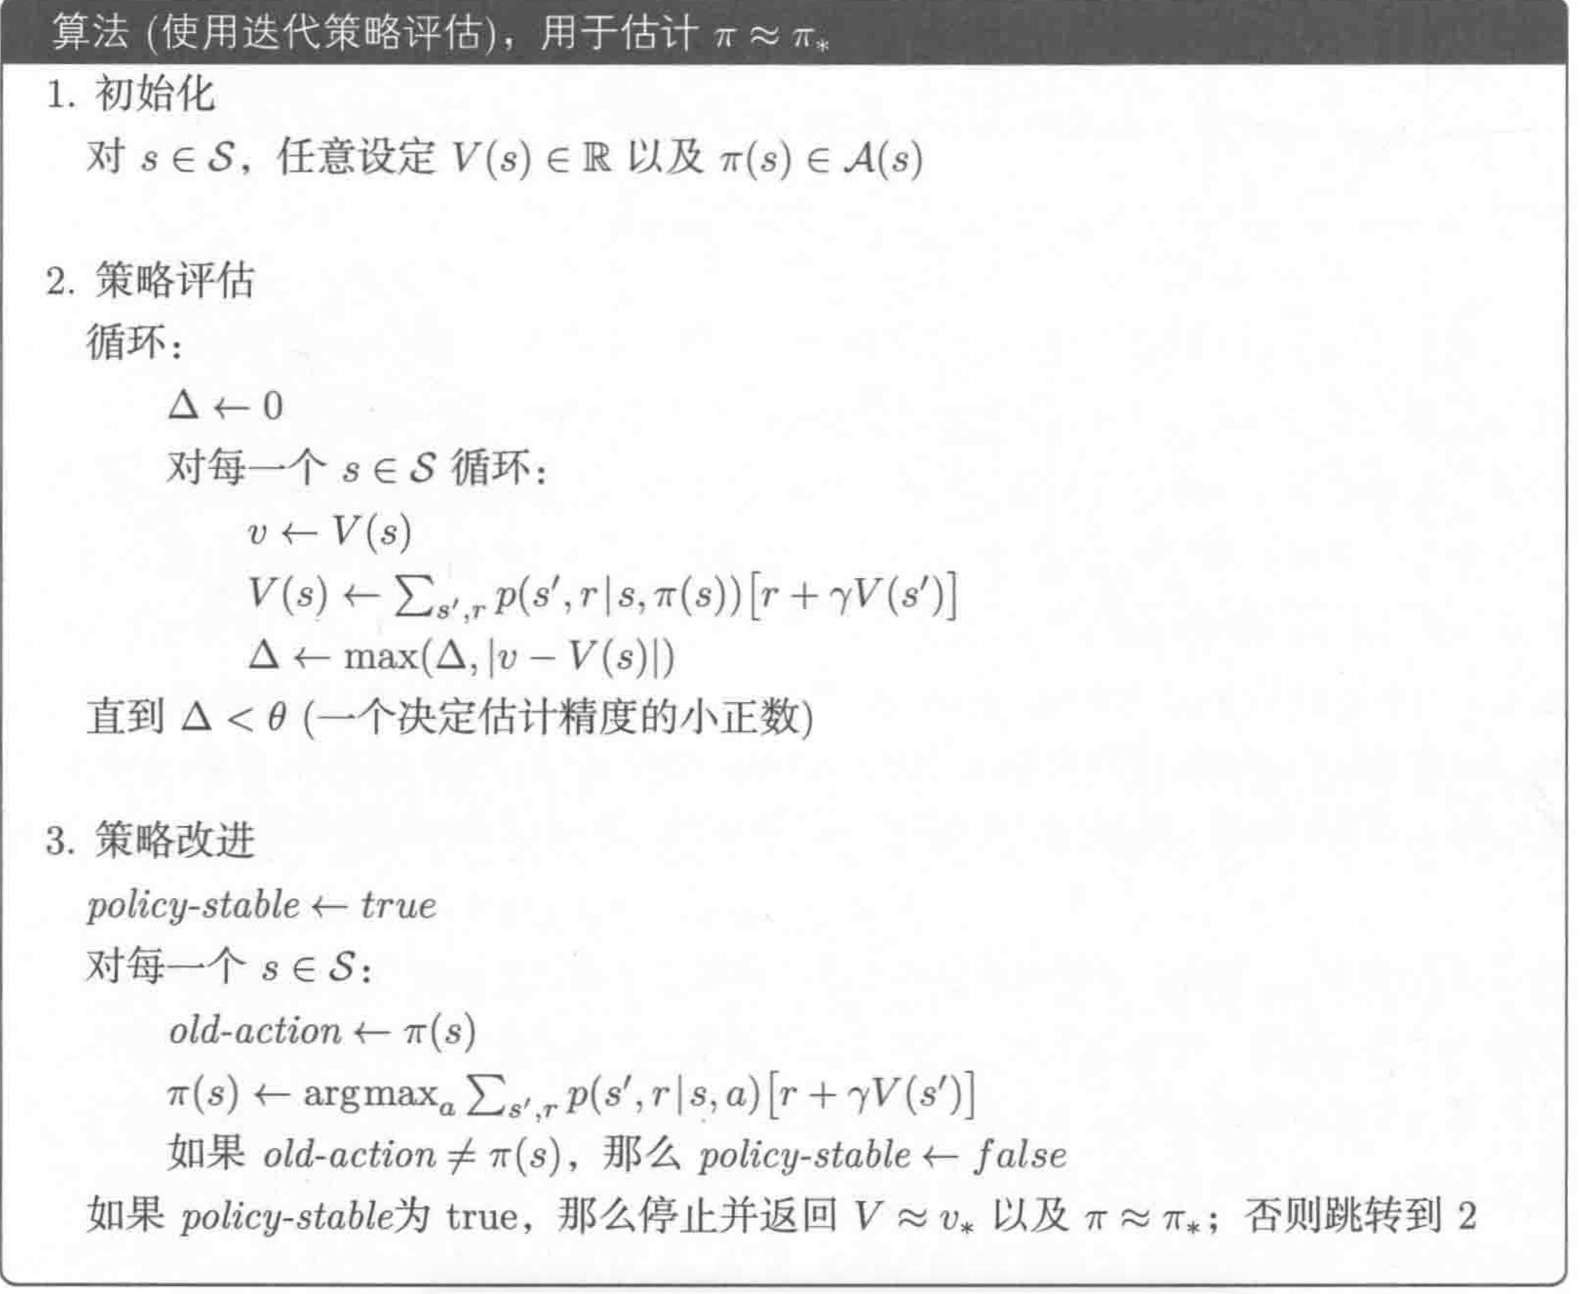

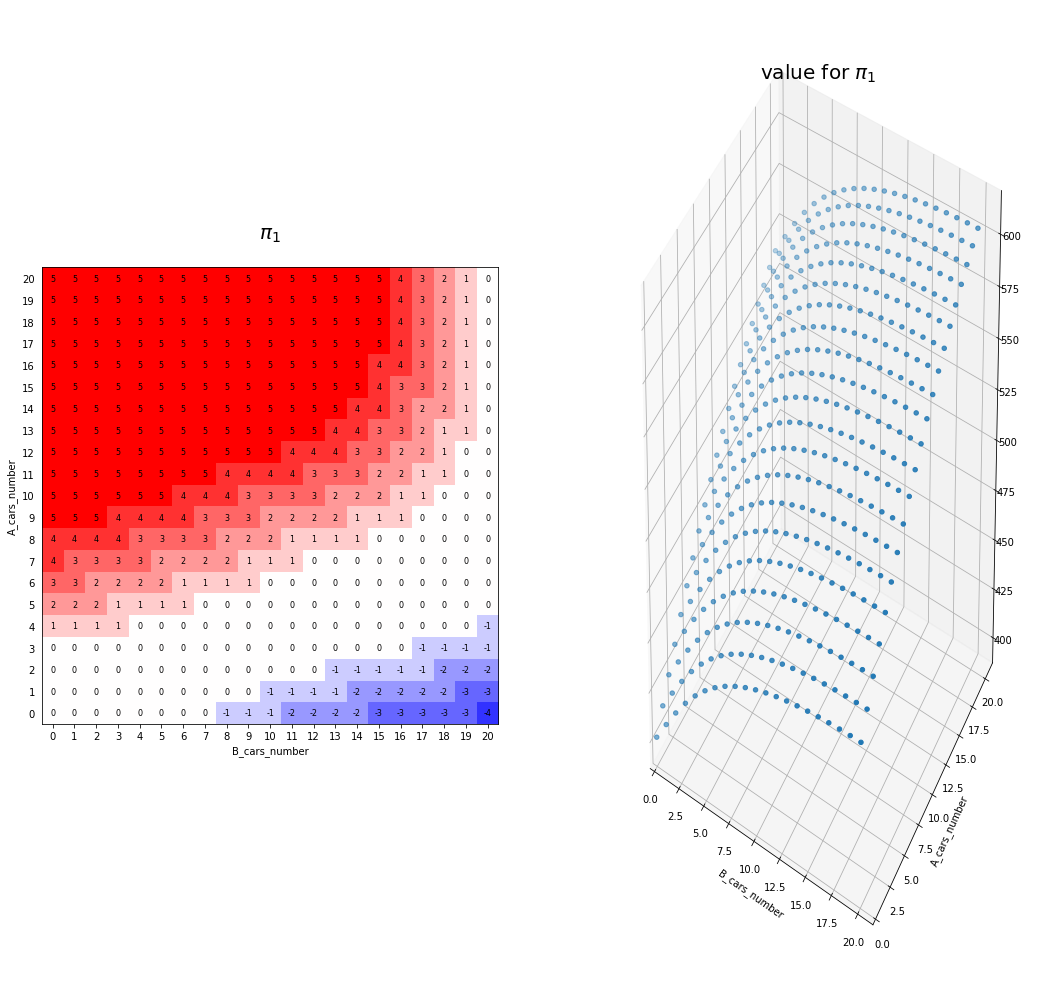

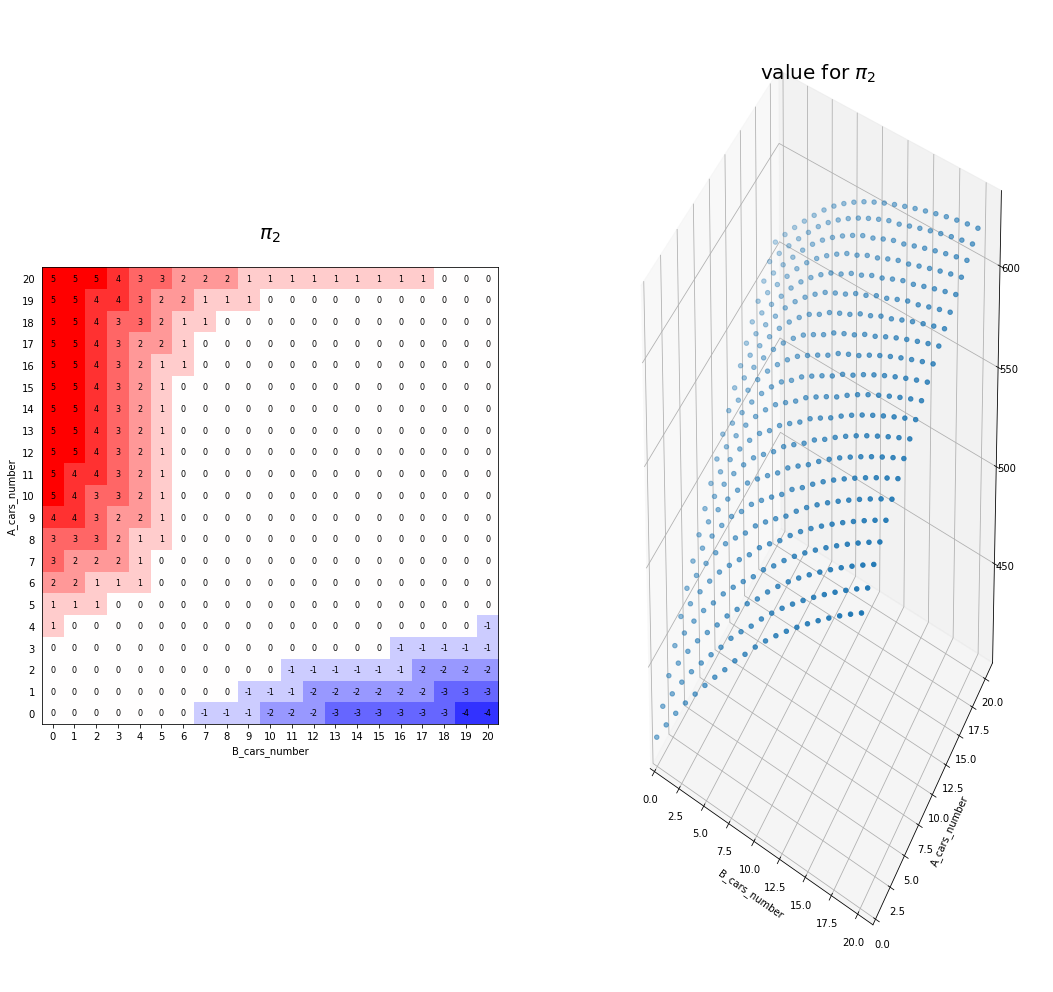

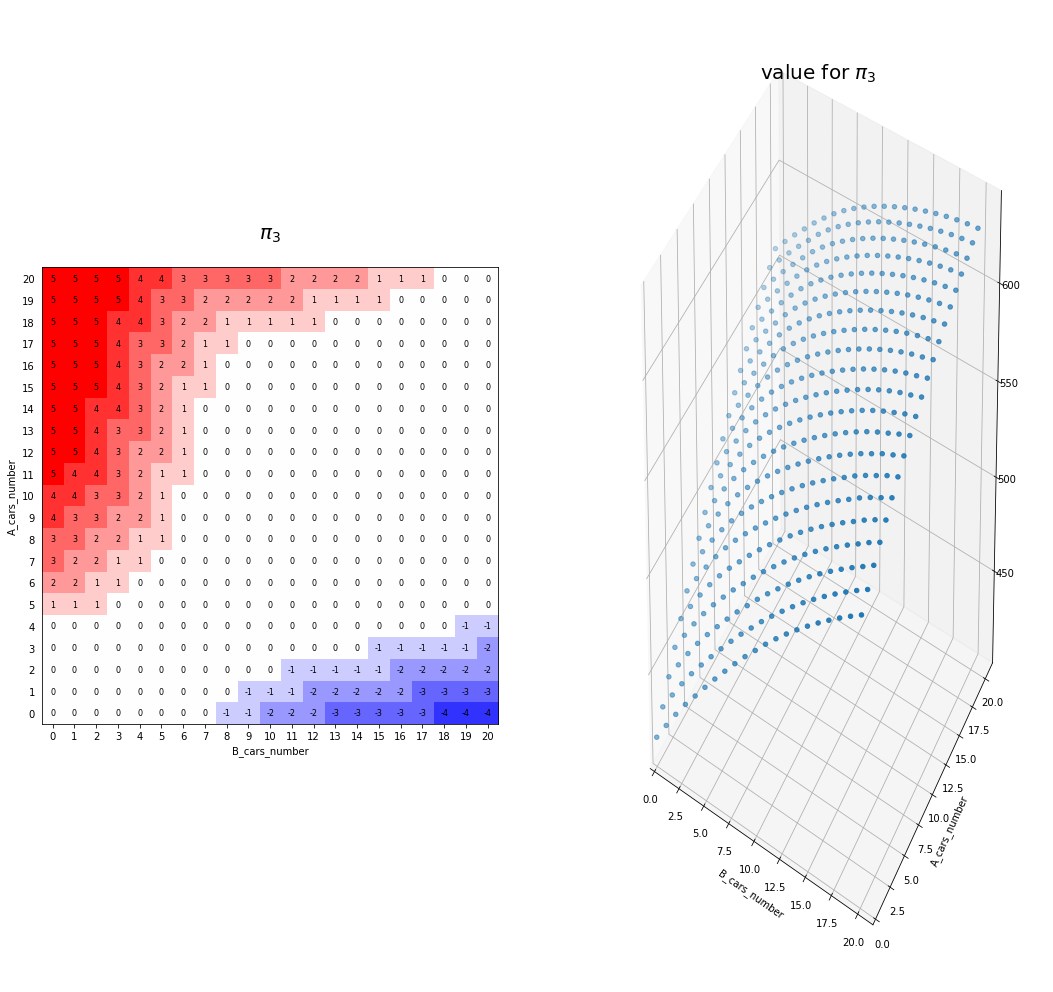

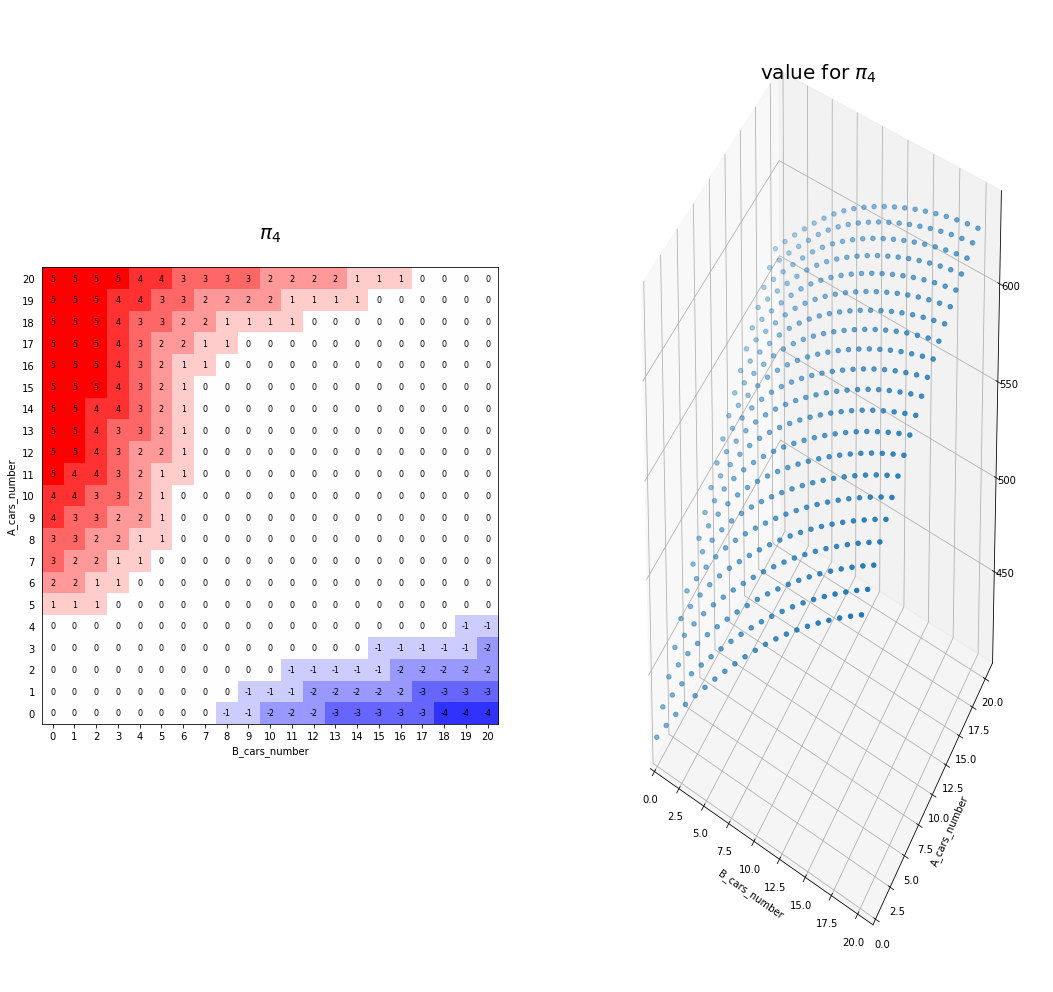

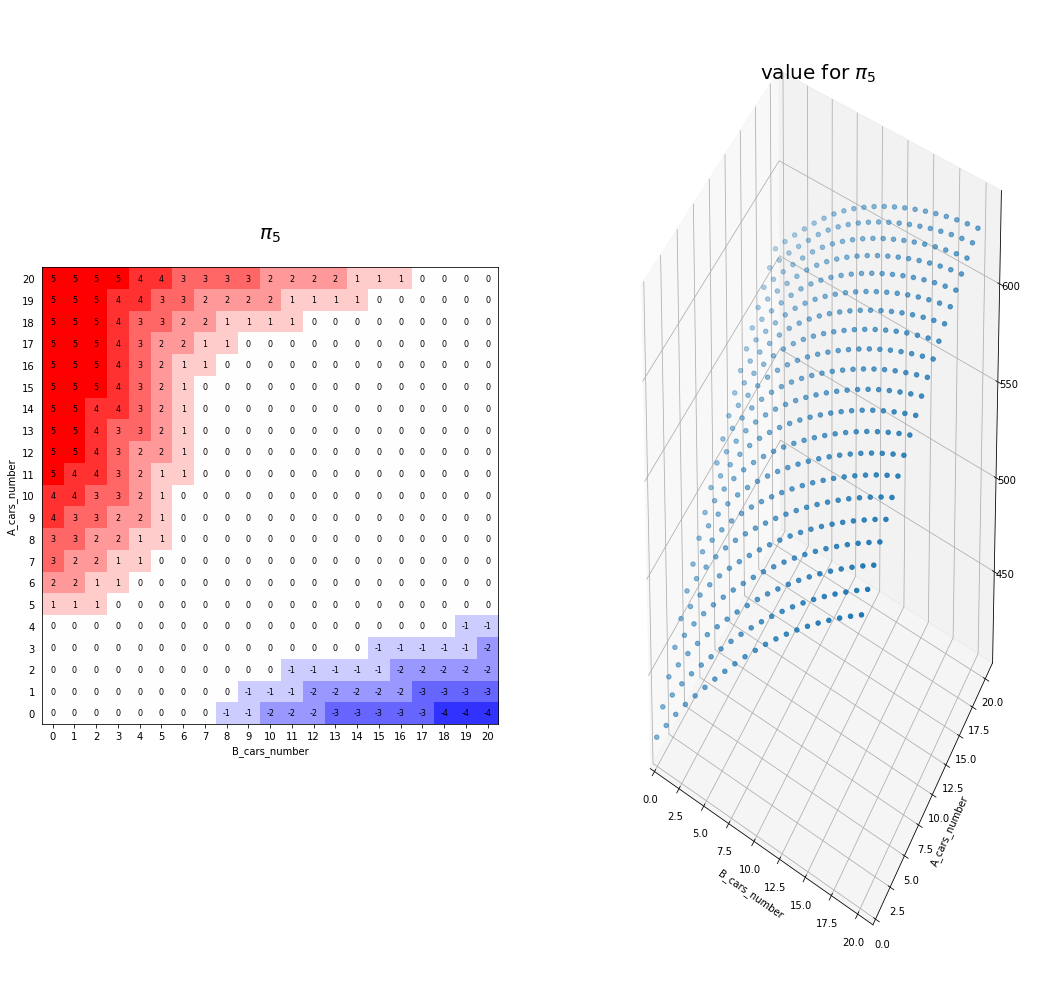

In [487]:
while True:
    while True:                  #策略评估
        pre_value=value.copy()   #保存旧value值
        for i in range(21):
            for j in range(21):
                value[i,j]=value_update([i,j],policy[i,j],value)#这里传入的value是更新后的value因此计算是实时更新的可以加快收敛速度
        max_delta=abs(pre_value-value).max()               #计算更新前后的差，判断是否满足收敛要求
        if max_delta<0.1:                                 #将收敛条件设置为0.1
            break    
    policy_stable=True
    for i in range(21):
        for j in range(21):
            old_action=policy[i,j]
            new_action=policy[i,j]
            old_value=value[i,j]
            for action in actions:                                       #遍历每一个action使用greedy算法
                if action>=-j and action<=i:
                    new_action_value=value_update([i,j],action,value)     #action不能超过最大租车数和地点最大容纳能力
                else:
                    new_action_value=-np.inf
                if new_action_value>=old_value:
                    new_action=action
                    old_value=new_action_value
            policy[i,j]=new_action
            if policy_stable and new_action!=old_action:
                policy_stable=False
    iteration+=1
    draw_graph(iteration)
    if policy_stable:
        break

iteration: 2, policy stable False
iteration: 3, policy stable False
iteration: 4, policy stable False
iteration: 5, policy stable True


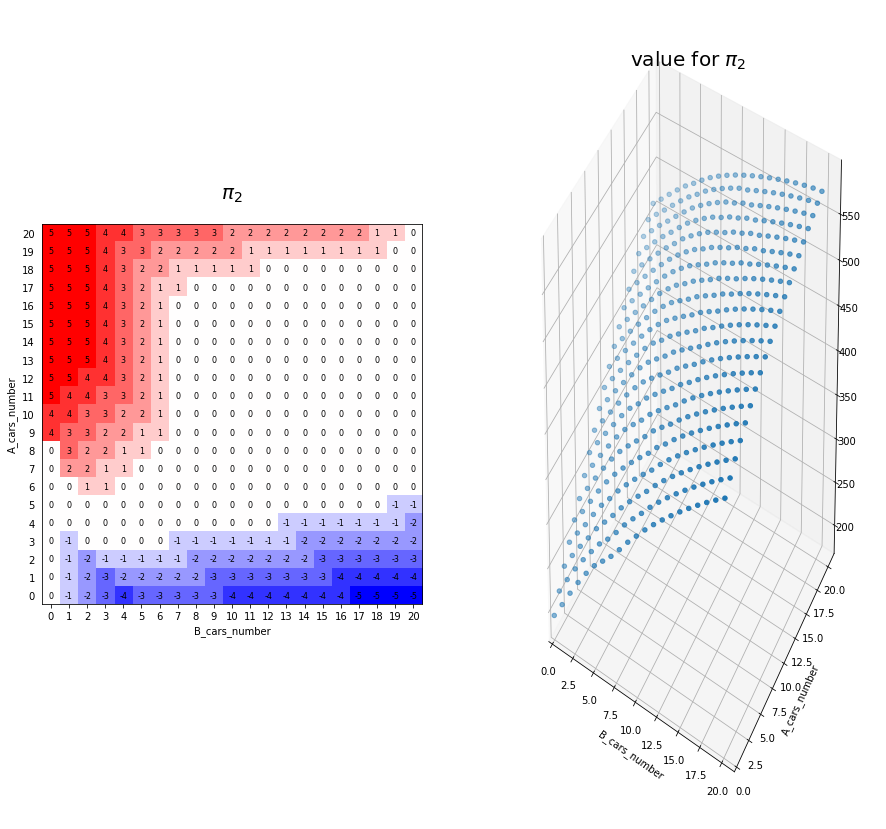

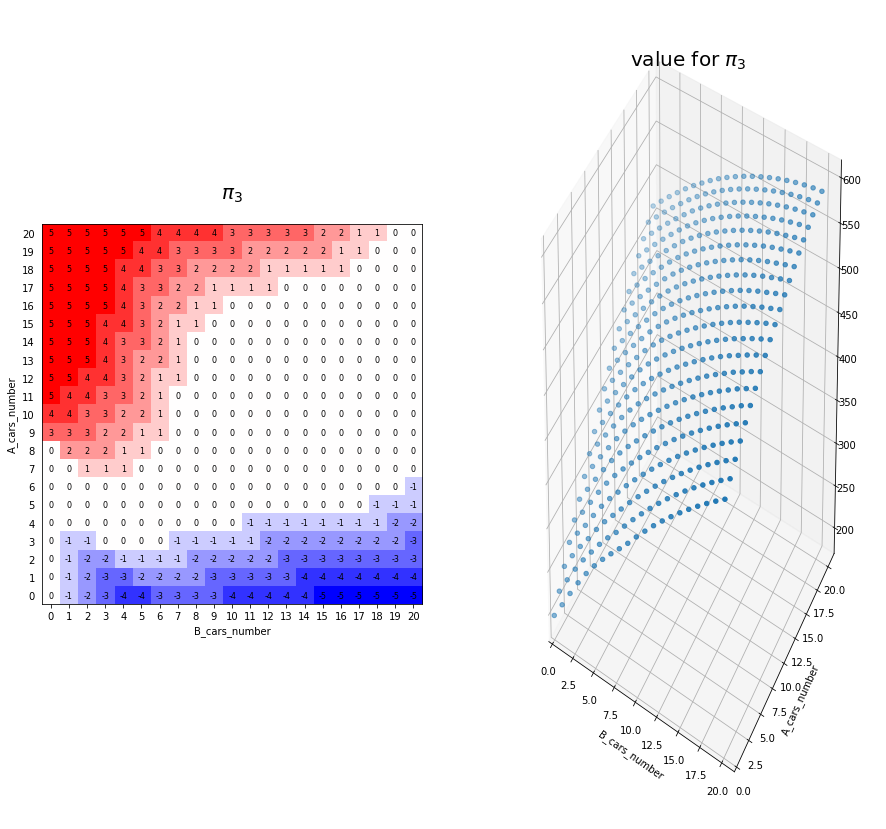

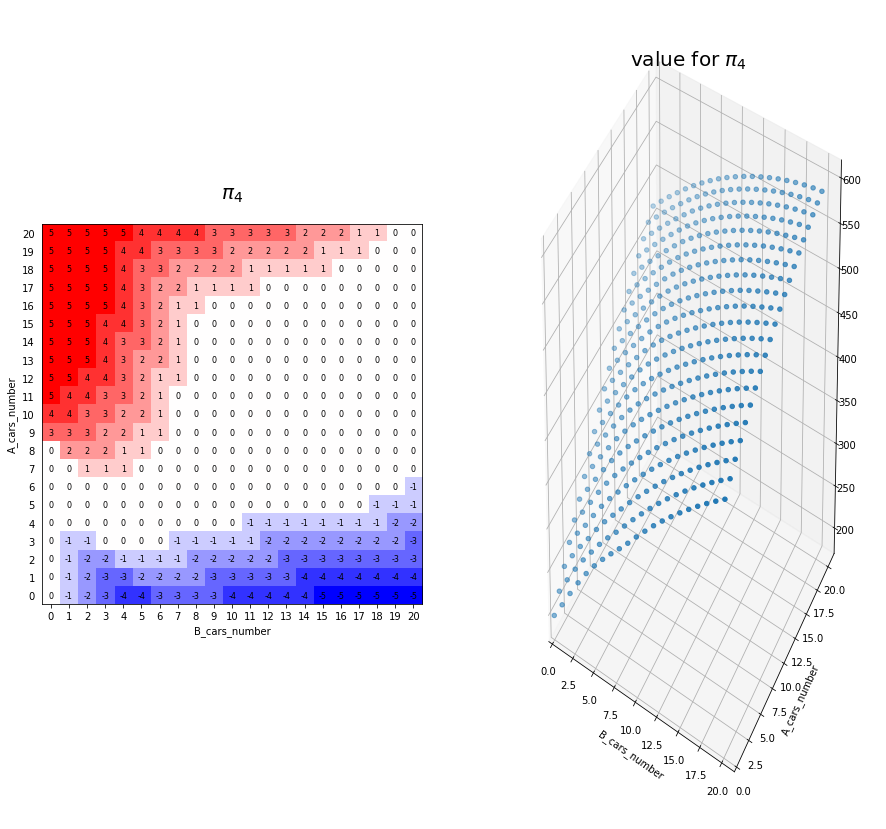

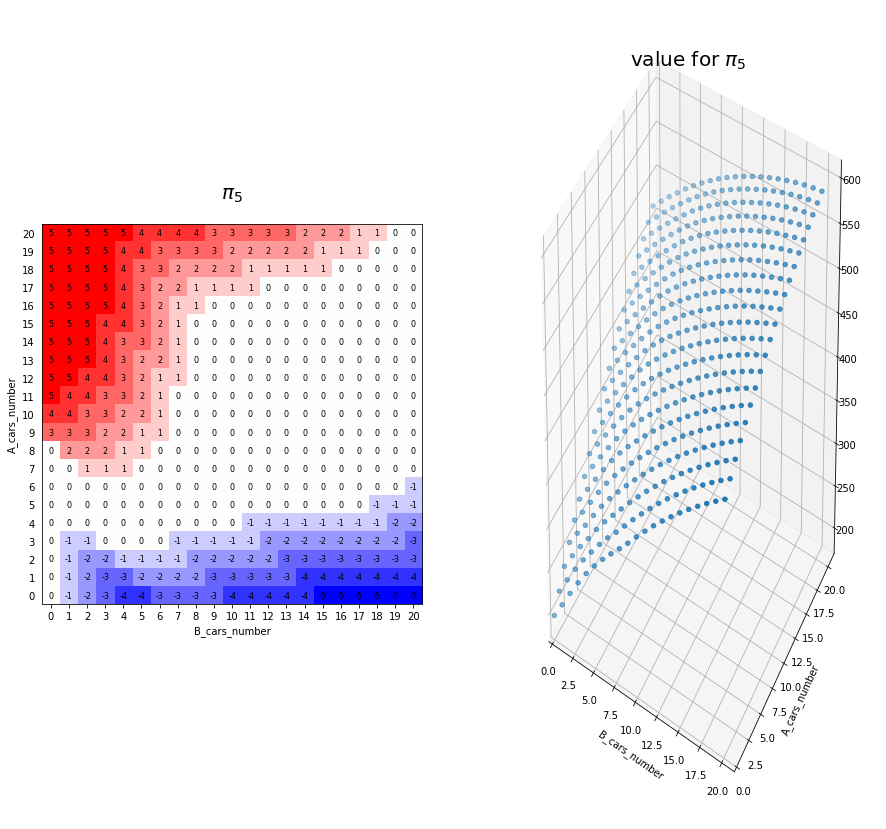

In [417]:
while True:
    while True:                  #策略评估
        pre_value=value.copy()   #保存旧value值
        for i in range(21):
            for j in range(21):
                value[i,j]=value_update([i,j],policy[i,j],value)#这里传入的value是更新后的value因此计算是实时更新的可以加快收敛速度
        max_delta=abs(pre_value-value).max()               #计算更新前后的差，判断是否满足收敛要求
        if max_delta<0.1:                                 #将收敛条件设置为0.1
            break    
    policy_stable = True
    for i in range(21):
        for j in range(21):
            old_action = policy[i, j]
            action_value = []
            # 遍历动作空间
            for action in actions:
                if -j <= action <= i:  # valid action
                    action_value.append(value_update([i, j], action, value))
                else:
                    action_value.append(-np.inf)
            action_value = np.array(action_value)
            # 贪婪选择，选择价值函数最大的动作
            new_action = actions[np.where(action_value == action_value.max())[0]]
            policy[i, j] = np.random.choice(new_action)
            if policy_stable and (old_action not in new_action):
                policy_stable = False
    iteration += 1
    print('iteration: {}, policy stable {}'.format(iteration, policy_stable))
    draw_graph(iteration)
    if policy_stable:
        break

In [488]:
print(value)

[[416.22107907 426.18294841 436.02849197 445.62358201 454.84591692
  463.62731359 471.95470571 479.84724526 487.69978637 495.18405813
  502.58401213 509.67771305 516.42263749 523.00817222 529.3891206
  535.4656962  541.25209952 546.76869273 552.17433567 557.3565604
  562.28428722]
 [426.0857383  436.04798661 445.8940191  455.48893755 464.71008086
  473.48942081 481.81418299 489.70371724 497.18797708 504.58787706
  511.68156651 518.4264804  525.01133056 531.39227141 537.46884019
  543.25523703 548.7718234  554.17646674 559.35868675 564.28640847
  568.9510744 ]
 [435.55211903 445.51431531 455.35928423 464.95065737 474.16498971
  482.93453081 491.24735926 499.12360357 506.59354503 513.68721809
  520.43211844 527.01641463 533.39734786 539.47391081 545.26030209
  550.7768815  556.1803564  561.36257278 566.29029069 570.95495148
  575.32234455]
 [444.36735357 454.32873346 464.1697607  473.75116281 482.94787857
  491.69278108 499.97608347 507.82008069 515.25623061 522.31461367
  529.02208569 5

## 总结 